In [1]:
import pandas as pd
import numpy as np 
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import tqdm
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings("ignore")
import joblib
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import joblib
import matplotlib.pyplot as plt

## Reading data after Feature Engineering

In [2]:
train_data=pd.read_csv('pilot_train_after_fe.csv')

In [3]:
train_data.head(5)

,Unnamed: 0,crew,time,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,...,eeg_f3_alpha_high,eeg_fz_alpha_high,eeg_f4_alpha_high,eeg_c4_alpha_high,eeg_p4_alpha_high,eeg_poz_alpha_high,eeg_c3_alpha_high,eeg_cz_alpha_high,eeg_o2_alpha_high,e
0,0,1,0.011719,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,23.712299,...,0.006548,0.001229,0.003105,0.004400,0.002121,0.001555,0.005902,0.002539,0.002471,0
1,1,1,0.015625,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,21.010300,...,0.006550,0.001437,0.003462,0.004586,0.002136,0.001555,0.005902,0.002572,0.002471,0
2,2,1,0.019531,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,25.431801,...,0.006552,0.001646,0.003818,0.004771,0.002151,0.001555,0.005902,0.002605,0.002471,0
3,3,1,0.023438,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,19.142799,...,0.006554,0.001854,0.004174,0.004957,0.002166,0.001555,0.005902,0.002638,0.002471,0
4,4,1,0.027344,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,20.572100,...,0.006556,0.002062,0.004531,0.005143,0.002181,0.001555,0.005902,0.002671,0.002471,0


In [4]:
train_data.columns

Index(['Unnamed: 0', 'crew', 'time', 'eeg_fp1', 'eeg_f7', 'eeg_f8', 'eeg_t4',
       'eeg_t6', 'eeg_t5', 'eeg_t3',
       ...
       'eeg_f3_alpha_high', 'eeg_fz_alpha_high', 'eeg_f4_alpha_high',
       'eeg_c4_alpha_high', 'eeg_p4_alpha_high', 'eeg_poz_alpha_high',
       'eeg_c3_alpha_high', 'eeg_cz_alpha_high', 'eeg_o2_alpha_high', 'e'],
      dtype='object', length=107)

In [5]:
# seperating into X and Y dataframes
X=train_data.drop(["e","Unnamed: 0"], axis=1)
Y=train_data["e"]

In [6]:
print("Total number of datapiint in Train Data = ", len(Y))
print("\n")
print("Features in the dataframe = \n", X.columns)
print("\n")
print("Total number of features = ", len(X.columns))

Total number of datapiint in Train Data =  4867421


Features in the dataframe = 
 Index(['crew', 'time', 'eeg_fp1', 'eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6',
       'eeg_t5', 'eeg_t3', 'eeg_fp2',
       ...
       'eeg_pz_alpha_high', 'eeg_f3_alpha_high', 'eeg_fz_alpha_high',
       'eeg_f4_alpha_high', 'eeg_c4_alpha_high', 'eeg_p4_alpha_high',
       'eeg_poz_alpha_high', 'eeg_c3_alpha_high', 'eeg_cz_alpha_high',
       'eeg_o2_alpha_high'],
      dtype='object', length=105)


Total number of features =  105


## Splitting dataframe into train and test data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=1)
print("X_train ====>", X_train.shape)
print("y_train ====>", y_train.shape)
print("X_test ====>", X_test.shape)
print("y_test ===>", y_test.shape)

X_train ====> (3650565, 105)
y_train ====> (3650565,)
X_test ====> (1216856, 105)
y_test ===> (1216856,)


## Data Preprocessing

In [8]:
# For converting all numerical features into particular scale we use standardization
std=StandardScaler()
std_trained=[]

In [9]:
# preprocessing filtered ecg, r, heart_rate, resp_rate and gsr signal
features=["ecg","r","gsr","resp_rate","heart_rate"]
for fea in tqdm(features):
    std.fit(X_train[fea].values.reshape(-1,1))
    X_train[fea]=std.transform(X_train[fea].values.reshape(-1,1))
    std_trained.append(std)
    X_test[fea]=std.transform(X_test[fea].values.reshape(-1,1))
    

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.58s/it]


In [10]:
# preprocessing eeg electrode data
eeg_features=['eeg_fp1', 'eeg_f7', 'eeg_f8','eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3','eeg_pz', 'eeg_f3',
              'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz','eeg_c3', 'eeg_cz', 'eeg_o2']

for fea in tqdm(eeg_features):
    std.fit(X_train[fea].values.reshape(-1,1))
    X_train[fea]=std.transform(X_train[fea].values.reshape(-1,1))
    std_trained.append(std)
    X_test[fea]=std.transform(X_test[fea].values.reshape(-1,1))
    

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


In [11]:
# preprocessing potential difference of ectrodes
potential_difference=["fp1_f7","f7_t3","t3_t5","t5_o1","p3_o1","c3_p3","f3_c3","fp1_f3","fz_cz",
"cz_pz","fp2_f4","f4_c4","c4_p4","p4_o2","t6_o2","t4_t6","f8_t4","fp2_f8"]
for fea in tqdm(potential_difference):
    std.fit(X_train[fea].values.reshape(-1,1))
    X_train[fea]=std.transform(X_train[fea].values.reshape(-1,1))
    std_trained.append(std)
    X_test[fea]=std.transform(X_test[fea].values.reshape(-1,1))

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:17<00:00,  1.03it/s]


In [12]:
# preprocessing alpha_low features
features=[i+"_alpha_low" for i in eeg_features]
for fea in tqdm(features):
    std.fit(X_train[fea].values.reshape(-1,1))
    X_train[fea]=std.transform(X_train[fea].values.reshape(-1,1))
    std_trained.append(std)
    X_test[fea]=std.transform(X_test[fea].values.reshape(-1,1))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.35it/s]


In [13]:
# preprocessing alpha_high features
features=[i+"_alpha_high" for i in eeg_features]
for fea in tqdm(features):
    std.fit(X_train[fea].values.reshape(-1,1))
    X_train[fea]=std.transform(X_train[fea].values.reshape(-1,1))
    std_trained.append(std)
    X_test[fea]=std.transform(X_test[fea].values.reshape(-1,1))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.05it/s]


In [14]:
# preprocessing theta features
features=[i+"_theta" for i in eeg_features]
for fea in tqdm(features):
    std.fit(X_train[fea].values.reshape(-1,1))
    X_train[fea]=std.transform(X_train[fea].values.reshape(-1,1))
    std_trained.append(std)
    X_test[fea]=std.transform(X_test[fea].values.reshape(-1,1))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.33it/s]


In [15]:
print(len(std_trained))
# storing standardization of each feature because we need these for transforming feature unseen points
np.save("std",std_trained) 

103


## Random Model

In [16]:
predicted_y = np.zeros((len(y_test),4))
for i in range(len(y_test)):
    rand_probs = np.random.rand(1,4)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log Loss on Test Data using Random Model", log_loss(y_test, predicted_y, eps=1e-15))


Log Loss on Test Data using Random Model 1.645268577540835


## Logistic Regression

In [17]:
LR = LogisticRegression()
LRparam_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}
LR_search = GridSearchCV(LR, param_grid=LRparam_grid, refit = True, verbose = 3, cv=3)

# fitting the model for grid search
LR_search.fit(X_train, y_train)
LR_search.best_params_
# summarize
print("Mean Accuracy: %.3f" % LR_search.best_score_)
print("Config: %s" % LR_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END .................C=0.001, penalty=l1;, score=nan total time=  11.2s
[CV 2/3] END .................C=0.001, penalty=l1;, score=nan total time=   1.6s
[CV 3/3] END .................C=0.001, penalty=l1;, score=nan total time=   1.6s
[CV 1/3] END ...............C=0.001, penalty=l2;, score=0.599 total time= 1.5min
[CV 2/3] END ...............C=0.001, penalty=l2;, score=0.596 total time= 1.4min
[CV 3/3] END ...............C=0.001, penalty=l2;, score=0.600 total time= 1.4min
[CV 1/3] END ..................C=0.01, penalty=l1;, score=nan total time=   1.8s
[CV 2/3] END ..................C=0.01, penalty=l1;, score=nan total time=   1.4s
[CV 3/3] END ..................C=0.01, penalty=l1;, score=nan total time=   1.4s
[CV 1/3] END ................C=0.01, penalty=l2;, score=0.599 total time= 1.5min
[CV 2/3] END ................C=0.01, penalty=l2;, score=0.598 total time= 1.7min
[CV 3/3] END ................C=0.01, penalty=l2;

In [18]:
LR_final=LogisticRegression(penalty='l2', C=1) # fitting the logistic regression using best tunned model
LR_final.fit(X_train, y_train)

LogisticRegression(C=1)

In [19]:
y_train_hat=LR_final.predict_proba(X_train) # finding test and train log_loss
y_test_hat=LR_final.predict_proba(X_test)
print("Train Data Log_loss =", log_loss(y_train, y_train_hat))
print("Test Data Log_loss = ", log_loss(y_test, y_test_hat))

Train Data Log_loss = 0.9403692399754654
Test Data Log_loss =  0.9405133975118541


## LightGBM (Light Gradient Boostin Machine)

In [20]:
params = {"n_estimators":[10,20,30,50,100],
          "num_leaves": range(1,50),
          "learning_rate": [1e-4, 0.0001,0.001,0.01,0.1],
          "bagging_fraction": list(np.arange(0.0,1.0,0.1)),
          "colsample_bytree": list(np.arange(0.0,1.0,0.1)),
          "min_data_in_leaf": [1,10,20,50,80,100],
            }

In [21]:
model = lgb.LGBMClassifier()
clf = RandomizedSearchCV(model,param_distributions=params,verbose=10)

In [22]:
clf.fit(X_train, y_train) # fitting LGBM model

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START bagging_fraction=0.30000000000000004, colsample_bytree=0.5, learning_rate=0.1, min_data_in_leaf=20, n_estimators=10, num_leaves=28
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[CV 1/5; 1/10] END bagging_fraction=0.30000000000000004, colsample_bytree=0.5, learning_rate=0.1, min_data_in_leaf=20, n_estimators=10, num_leaves=28;, score=0.889 total time=  34.3s
[CV 2/5; 1/10] START bagging_fraction=0.30000000000000004, colsample_bytree=0.5, learning_rate=0.1, min_data_in_leaf=20, n_estimators=10, num_leaves=28
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.300000000000

[CV 4/5; 3/10] END bagging_fraction=0.6000000000000001, colsample_bytree=0.2, learning_rate=0.1, min_data_in_leaf=20, n_estimators=30, num_leaves=10;, score=0.751 total time=  28.5s
[CV 5/5; 3/10] START bagging_fraction=0.6000000000000001, colsample_bytree=0.2, learning_rate=0.1, min_data_in_leaf=20, n_estimators=30, num_leaves=10
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[CV 5/5; 3/10] END bagging_fraction=0.6000000000000001, colsample_bytree=0.2, learning_rate=0.1, min_data_in_leaf=20, n_estimators=30, num_leaves=10;, score=0.745 total time=  28.0s
[CV 1/5; 4/10] START bagging_fraction=0.30000000000000004, colsample_bytree=0.9, learning_rate=0.001, min_data_in_leaf=1, n_estimators=10, num_leaves=18
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_sampl

[CV 3/5; 6/10] END bagging_fraction=0.6000000000000001, colsample_bytree=0.30000000000000004, learning_rate=0.0001, min_data_in_leaf=10, n_estimators=50, num_leaves=18;, score=0.585 total time=  51.0s
[CV 4/5; 6/10] START bagging_fraction=0.6000000000000001, colsample_bytree=0.30000000000000004, learning_rate=0.0001, min_data_in_leaf=10, n_estimators=50, num_leaves=18
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[CV 4/5; 6/10] END bagging_fraction=0.6000000000000001, colsample_bytree=0.30000000000000004, learning_rate=0.0001, min_data_in_leaf=10, n_estimators=50, num_leaves=18;, score=0.585 total time=  49.0s
[CV 5/5; 6/10] START bagging_fraction=0.6000000000000001, colsample_bytree=0.30000000000000004, learning_rate=0.0001, min_data_in_leaf=10, n_estimators=50, num

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[CV 3/5; 9/10] END bagging_fraction=0.1, colsample_bytree=0.2, learning_rate=0.0001, min_data_in_leaf=100, n_estimators=20, num_leaves=26;, score=0.585 total time=  27.8s
[CV 4/5; 9/10] START bagging_fraction=0.1, colsample_bytree=0.2, learning_rate=0.0001, min_data_in_leaf=100, n_estimators=20, num_leaves=26
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[CV 4/5; 9/10] END bagging_fraction=0.1, colsample_bytree=0.2, learning_rate=0.0001, min_data_in_leaf=100, n_estimators=20, num_leaves=26;, score=0.585 total time=  26.2s
[CV 5/5; 9/10] START bagging_fractio

RandomizedSearchCV(estimator=LGBMClassifier(),
                   param_distributions={'bagging_fraction': [0.0, 0.1, 0.2,
                                                             0.30000000000000004,
                                                             0.4, 0.5,
                                                             0.6000000000000001,
                                                             0.7000000000000001,
                                                             0.8, 0.9],
                                        'colsample_bytree': [0.0, 0.1, 0.2,
                                                             0.30000000000000004,
                                                             0.4, 0.5,
                                                             0.6000000000000001,
                                                             0.7000000000000001,
                                                             0.8, 0.9],
                                        'learning_rate': [0.0001, 0.0001, 0.001,
                                                          0.01, 0.1],
                                        'min_data_in_leaf': [1, 10, 20, 50, 80,
                                                             100],
                                        'n_estimators': [10, 20, 30, 50, 100],
                                        'num_leaves': range(1, 50)},
                   verbose=10)

In [44]:
best_params = {'num_leaves': 41,
 'n_estimators': 50,
 'min_data_in_leaf': 1,
 'learning_rate': 0.1,
 'colsample_bytree': 0.5,
 'bagging_fraction': 0.2}

In [34]:
clf=lgb.LGBMClassifier(objective="multiclass",num_classes=4,metric="multi_logloss",**best_params) # fitting on best hyper parameters
clf.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2


LGBMClassifier(bagging_fraction=0.2, colsample_bytree=0.5,
               metric='multi_logloss', min_data_in_leaf=1, n_estimators=50,
               num_classes=4, num_leaves=41, objective='multiclass')

In [35]:
y_train_hat=clf.predict_proba(X_train)
y_test_hat=clf.predict_proba(X_test)

In [36]:
print("Train log loss =",log_loss(y_train,y_train_hat))
print("Test log loss = ",log_loss(y_test,y_test_hat))


Train log loss = 0.1403701990809393
Test log loss =  0.14076719965163834


In [47]:
print("Lowest Train log_loss and Test log_loss were: \n")
print("Train log loss = 0.10765265989508259")
print("Test log loss =  0.10794974027824296")

Lowest Train log_loss and Test log_loss were: 

Train log loss = 0.10765265989508259
Test log loss =  0.10794974027824296


In [37]:
# saving the best model on a pickle file
joblib.dump(clf, 'final_model1.pkl')

['final_model1.pkl']

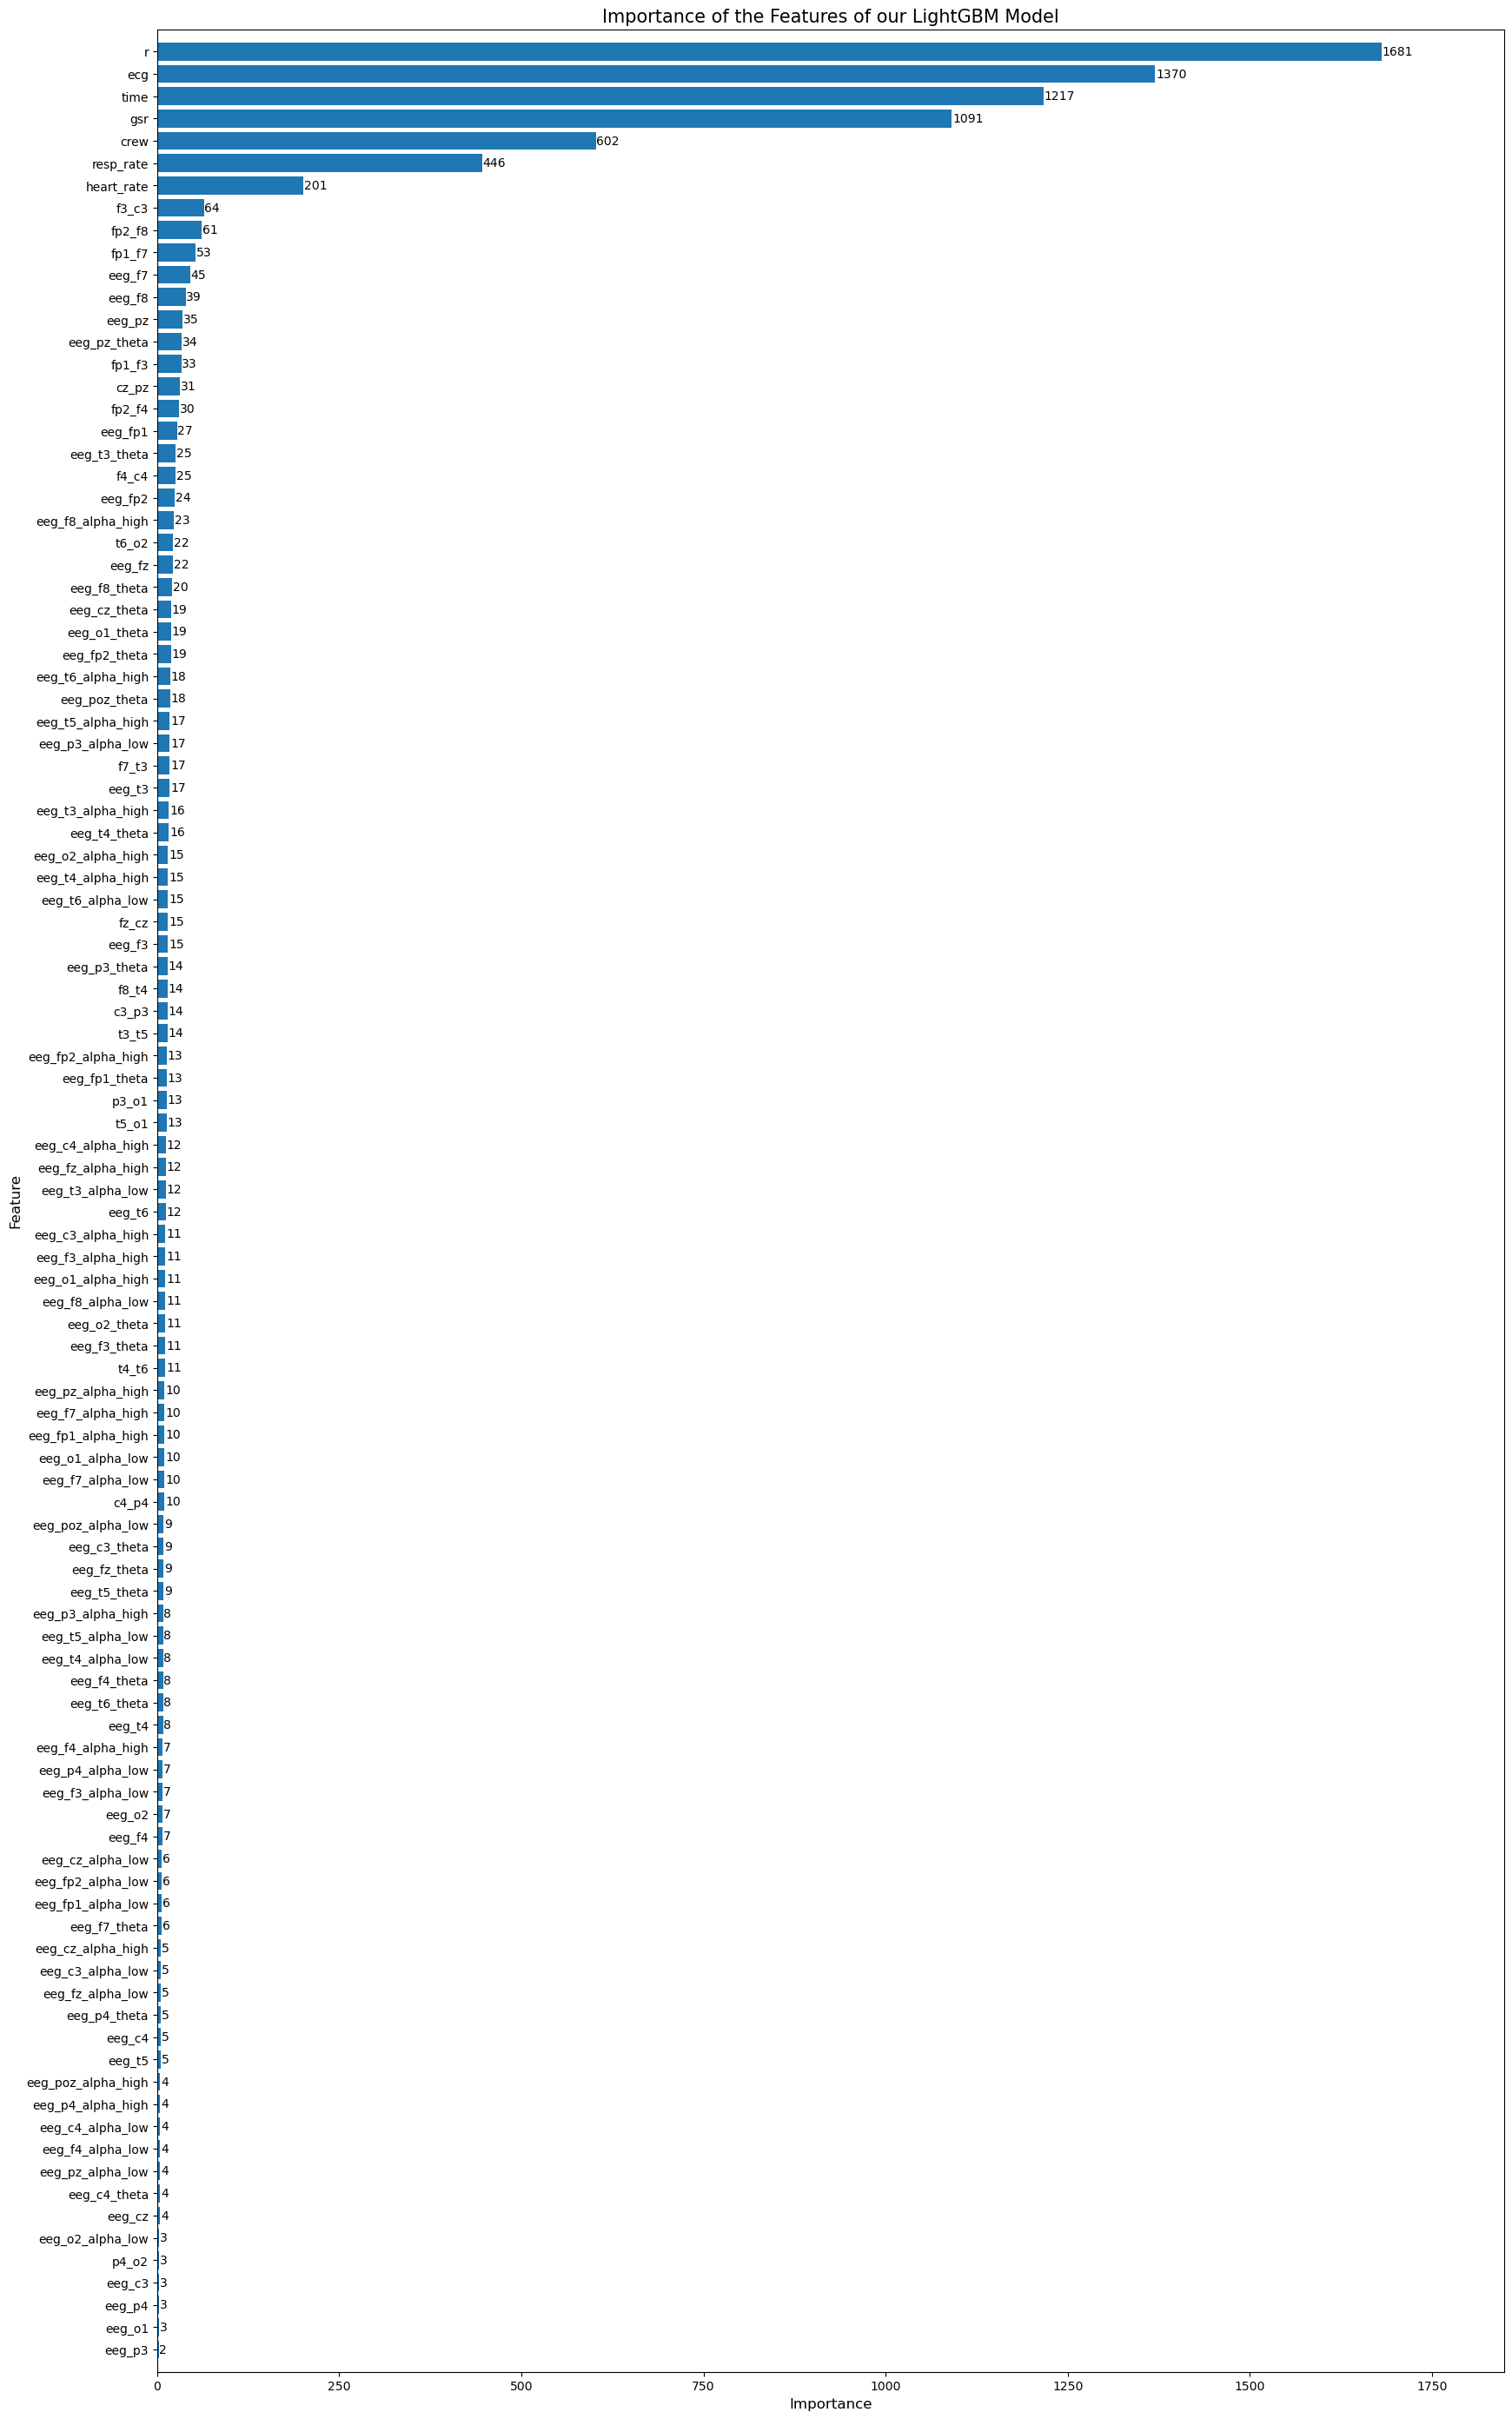

In [39]:
fig, ax = plt.subplots(figsize=(20,35))
lgb.plot_importance(clf, height=0.8, ax=ax)
ax.grid(False)
plt.ylabel('Feature', size=12)
plt.xlabel('Importance', size=12)
plt.title("Importance of the Features of our LightGBM Model", fontsize=15)
plt.show()

In [42]:
from prettytable import PrettyTable 
myTable = PrettyTable(["Sl.no", "Model", "log_loss"]) 
myTable.add_row(["1", "Random Model", "1.645"]) 
myTable.add_row(["2", "Logistic Regression", "0.944" ]) 
myTable.add_row(["3", "Light GBM", "0.107"]) 
print(myTable)

+-------+---------------------+----------+
| Sl.no |        Model        | log_loss |
+-------+---------------------+----------+
|   1   |     Random Model    |  1.645   |
|   2   | Logistic Regression |  0.944   |
|   3   |      Light GBM      |  0.107   |
+-------+---------------------+----------+


## AdaBoost

In [29]:
# Since AdaBoost model took very long time to train the data, I decided to use a mean of the score I received
# for 0.01 and 0.1 learning rates and print the output manually and also using a screen picture from the outputs until 
# the time I decided to stop the model. For this reason I am commenting the code below and classify AdaBoost model 
# as not the best model for this use case

#from sklearn.ensemble import AdaBoostClassifier

#params = {"n_estimators":[50],          
#        "learning_rate" : [0.01,0.1]    
#          }

In [30]:
#AdaBoost=AdaBoostClassifier()
#Adaboost = GridSearchCV(AdaBoost,params,verbose=10)
#Adaboost.fit(X_train.iloc[2174115:],y_train.iloc[2174115:])

print("AdaBoost model output score for 6 fits out of 10 : \n")
print("\n")
print("Fitting 5 folds for each of 2 candidates, totalling 10 fits \n [CV 1/5; 1/2] START learning_rate=0.01, n_estimators=50......................... \n [CV 1/5; 1/2] END learning_rate=0.01, n_estimators=50;, score=0.604 total time=30.2min \n [CV 2/5; 1/2] START learning_rate=0.01, n_estimators=50.........................\n [CV 2/5; 1/2] END learning_rate=0.01, n_estimators=50;, score=0.604 total time=28.2min \n [CV 3/5; 1/2] START learning_rate=0.01, n_estimators=50......................... \n [CV 3/5; 1/2] END learning_rate=0.01, n_estimators=50;, score=0.604 total time=29.4min \n [CV 4/5; 1/2] START learning_rate=0.01, n_estimators=50......................... \n [CV 4/5; 1/2] END learning_rate=0.01, n_estimators=50;, score=0.605 total time=32.8min \n [CV 5/5; 1/2] START learning_rate=0.01, n_estimators=50......................... \n [CV 5/5; 1/2] END learning_rate=0.01, n_estimators=50;, score=0.604 total time=35.8min \n [CV 1/5; 2/2] START learning_rate=0.1, n_estimators=50.......................... \n [CV 1/5; 2/2] END learning_rate=0.1, n_estimators=50;, score=0.591 total time=29.7min \n [CV 2/5; 2/2] START learning_rate=0.1, n_estimators=50..........................")

AdaBoost model output score for 6 fits out of 10 : 



Fitting 5 folds for each of 2 candidates, totalling 10 fits 
 [CV 1/5; 1/2] START learning_rate=0.01, n_estimators=50......................... 
 [CV 1/5; 1/2] END learning_rate=0.01, n_estimators=50;, score=0.604 total time=30.2min 
 [CV 2/5; 1/2] START learning_rate=0.01, n_estimators=50.........................
 [CV 2/5; 1/2] END learning_rate=0.01, n_estimators=50;, score=0.604 total time=28.2min 
 [CV 3/5; 1/2] START learning_rate=0.01, n_estimators=50......................... 
 [CV 3/5; 1/2] END learning_rate=0.01, n_estimators=50;, score=0.604 total time=29.4min 
 [CV 4/5; 1/2] START learning_rate=0.01, n_estimators=50......................... 
 [CV 4/5; 1/2] END learning_rate=0.01, n_estimators=50;, score=0.605 total time=32.8min 
 [CV 5/5; 1/2] START learning_rate=0.01, n_estimators=50......................... 
 [CV 5/5; 1/2] END learning_rate=0.01, n_estimators=50;, score=0.604 total time=35.8min 
 [CV 1/5; 2/2] START lear

In [31]:
from lazypredict.Supervised import LazyClassifier

In [32]:
#clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
#models,predictions = clf.fit(X_train, X_test, y_train, y_test)

# print(models)